In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from collections import Counter

%matplotlib inline

/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# uncomment the group you want to train on
race = "hispanic"
#race = "white"
#race = "mixed"

In [71]:
X = np.load('../Data/' + race + '/X.npy')
Y2 = np.load('../Data/' + race + '/Y2.npy')

In [72]:
size_hispanic = 37575

In [73]:
X.shape

(37575, 301)

In [74]:
# shuffle
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y2[idx]

#if race != 'hispanic':
#   X = X[:size_hispanic]
#    Y = Y[:size_hispanic]

TEST_SET_SIZE = int(0.1*len(Y))

X_train, X_test = X[:-TEST_SET_SIZE], X[-TEST_SET_SIZE:]
Y_train, Y_test = Y[:-TEST_SET_SIZE].astype(int), Y[-TEST_SET_SIZE:].astype(int)

In [6]:
X.shape

(37575, 301)

In [75]:
# Features Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
X_train[:,-4:] = std_scaler.fit_transform(X_train[:,-4:])
X_test[:,-4:] = std_scaler.transform(X_test[:,-4:])

mm_scaler = MinMaxScaler(feature_range=(-1,1))
X_train[:,:-4] = mm_scaler.fit_transform(X_train[:,:-4])
X_test[:,:-4] = mm_scaler.transform(X_test[:,:-4])

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [76]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def results(classifier,threshold=0.5, X_test=X_test, Y_test=Y_test):
    Y_pred_test = classifier.predict(X_test)
    Y_pred_test = (Y_pred_test>=threshold).astype(int)
    #Y_pred_test = np.rint(Y_pred_test)
    print("Test accuracy score: " + str(accuracy_score(Y_test.astype(int), Y_pred_test)))
    print("ROC: " + str(roc_auc_score(Y_test, classifier.predict(X_test))))
    #print("ROC: " + str(roc_auc_score(Y_test, Y_pred_test)))
    matrix = confusion_matrix(Y_test.astype(int), Y_pred_test)
    tn, fp, fn, tp = matrix.ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    g_mean = np.sqrt(sensitivity*specificity)
    print("PPV: " + str(ppv))
    print("NPV: " + str(npv))
    print("Sensitivity: " + str(sensitivity))
    print("Specificity: " + str(specificity))
    print("G-Mean: " + str(g_mean))
    print("Confusion matrix:\n" + str(matrix))

## Undersample

In [162]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler(ratio={0:6087, 1:20000})
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

In [78]:
X_train.shape

(33818, 301)

## ConvNet

In [158]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import roc_auc_score

model = Sequential()
model.add(Conv1D(16, kernel_size=15, strides=1,
                 activation='relu', padding="same",
                 input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2, strides=None))
#model.add(Conv1D(12, kernel_size=3, strides=1,
                # activation='relu'))
#model.add(MaxPooling1D(pool_size=2, strides=None))
#model.add(Conv1D(64, (5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [159]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape((-1, X_train.shape[1],1)), Y_train, epochs=10, batch_size=200,)

scores = model.evaluate(X_test.reshape(-1,X_test.shape[1],1), Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
33818/33818 [==============================] - 4s 126us/step - loss: 0.3773 - acc: 0.8394
Epoch 2/10
33818/33818 [==============================] - 3s 101us/step - loss: 0.3310 - acc: 0.8540
Epoch 3/10
33818/33818 [==============================] - 3s 102us/step - loss: 0.3276 - acc: 0.8550
Epoch 4/10
33818/33818 [==============================] - 3s 101us/step - loss: 0.3260 - acc: 0.8575
Epoch 5/10
33818/33818 [==============================] - 3s 102us/step - loss: 0.3235 - acc: 0.8576
Epoch 6/10
33818/33818 [==============================] - 3s 102us/step - loss: 0.3209 - acc: 0.8599
Epoch 7/10
33818/33818 [==============================] - 3s 101us/step - loss: 0.3205 - acc: 0.8605
Epoch 8/10
33818/33818 [==============================] - 3s 102us/step - loss: 0.3183 - acc: 0.8617
Epoch 9/10
33818/33818 [==============================] - 3s 102us/step - loss: 0.3170 - acc: 0.8612
Epoch 10/10
3757/3757 [==============================] - 1s 179us/step

acc: 85.79%


In [160]:
results(model, X_test=X_test.reshape(-1,X_test.shape[1],1))

Test accuracy score: 0.8578653180729305
ROC: 0.8716719310247788
PPV: 0.9029003783102144
NPV: 0.6136752136752137
Sensitivity: 0.9268608414239482
Specificity: 0.5382308845577212
G-Mean: 0.7063038514276454
Confusion matrix:
[[ 359  308]
 [ 226 2864]]


## Train

In [35]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

model = Sequential()

model.add(Dense(400, kernel_initializer='he_normal', input_dim=X.shape[1], name='layer1'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(400, kernel_initializer='he_normal',name='layer2'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(400, kernel_initializer='he_normal',name='layer3'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(1, activation='sigmoid'))

In [11]:
from keras.optimizers import Adam, Adadelta
adam_opt = Adam(lr=.1)
adagrad_opt = Adadelta()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=5, batch_size=250)
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/5
33818/33818 [==============================] - 2s 66us/step - loss: 0.3688 - acc: 0.8401
Epoch 2/5
33818/33818 [==============================] - 2s 55us/step - loss: 0.3381 - acc: 0.8498
Epoch 3/5
33818/33818 [==============================] - 2s 56us/step - loss: 0.3326 - acc: 0.8512
Epoch 4/5
33818/33818 [==============================] - 2s 56us/step - loss: 0.3334 - acc: 0.8542
Epoch 5/5
3757/3757 [==============================] - 0s 73us/step

acc: 85.68%


In [13]:
results(model, threshold=0.5)

Test accuracy score: 0.8568006388075592
ROC: 0.8723366472103754
PPV: 0.8897373243738547
NPV: 0.6335403726708074
Sensitivity: 0.9427184466019417
Specificity: 0.4587706146926537
G-Mean: 0.6576408755769949
Confusion matrix:
[[ 306  361]
 [ 177 2913]]


(array([  189.,   703.,  1011.,  1141.,  1029.,  1127.,  1349.,  1914.,
         3758., 21597.]),
 array([0.14018634, 0.22614742, 0.3121085 , 0.39806959, 0.48403067,
        0.56999175, 0.65595284, 0.74191392, 0.827875  , 0.91383608,
        0.99979717]),
 <a list of 10 Patch objects>)

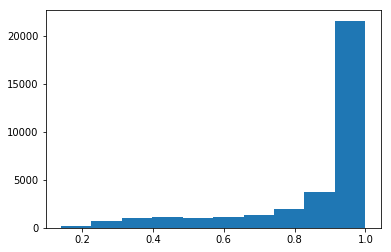

In [174]:
plt.hist(model.predict(X_train))

In [159]:
Y_pred1 = (model.predict(X_test)>0.5).astype(int)
print(accuracy_score(Y_test, Y_pred1))
confusion_matrix(Y_test, Y_pred1)

0.8522757519297312


array([[ 384,  283],
       [ 272, 2818]])

In [285]:
l1 = model.get_layer("layer1")
l1.get_weights()[0].ravel()

array([-0.02789835,  0.02168945,  0.01079839, ..., -0.02229493,
       -0.01450237, -0.04505375], dtype=float32)

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 4.0000e+01, 3.3980e+03, 1.8989e+04, 3.5773e+04,
        3.7403e+04, 2.0493e+04, 4.2600e+03, 3.7000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ]),
 <a list of 30 Patch objects>)

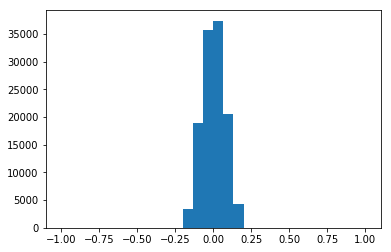

In [99]:
l1 = model.get_layer("layer1")
plt.hist(l1.get_weights()[0].ravel(), bins=30, range=(-1,1))

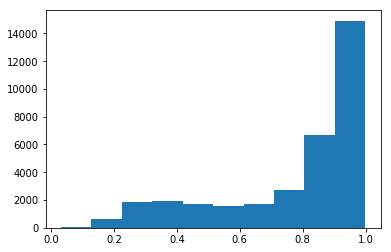

In [164]:
plt.hist(model.predict(X_train))
plt.show()

In [203]:
pred = model.predict(X_test)
idx = np.where(pred<0.3)[0]

In [174]:
for i in range(len(idx)):
    print(pred[i], Y_test[i])

[0.97772026] 1
[0.9541617] 1
[0.5386401] 0
[0.9818792] 1
[0.9157739] 0
[0.96501845] 1
[0.9708846] 1
[0.9781009] 1
[0.42925888] 0
[0.997959] 1
[0.5404831] 0
[0.9827959] 1
[0.7582309] 1
[0.8819169] 0
[0.9573313] 1
[0.959993] 1
[0.48295692] 0
[0.97830987] 1
[0.995999] 1
[0.5414268] 0
[0.83401334] 1
[0.51236796] 0
[0.9929508] 1
[0.91685] 1
[0.90754074] 1
[0.9852047] 1
[0.9879489] 1
[0.99886703] 1
[0.5496952] 1
[0.95478874] 1
[0.9839409] 1
[0.772484] 1
[0.9964713] 1
[0.98914206] 1
[0.9782548] 1
[0.96966076] 1
[0.9785876] 1
[0.68058294] 0
[0.99516016] 1
[0.9911753] 1
[0.98937434] 1
[0.8199292] 1
[0.8899329] 0
[0.6321105] 1
[0.98199743] 1
[0.95295465] 1
[0.9915103] 1
[0.862754] 1
[0.98961675] 1
[0.9313016] 0
[0.79055405] 1
[0.9465383] 1
[0.9994234] 1
[0.97542727] 1
[0.8631533] 0
[0.99776244] 1
[0.99757415] 1
[0.97010976] 1
[0.86313045] 1
[0.99683326] 1
[0.99865025] 1
[0.9983937] 1
[0.9874942] 1
[0.88709706] 1
[0.9496948] 0
[0.9882946] 1
[0.9689556] 1
[0.94108176] 1
[0.9836093] 1
[0.97141504] 